In [1]:
from torchvision.datasets import MNIST
from torchvision import transforms
import torch

from torch import nn
import numpy as np
import matplotlib.pylab as plt

In [2]:
torch.manual_seed(0)

def get_free_gpu():
    from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetCount
    nvmlInit()

    return np.argmax([
        nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(i)).free
        for i in range(nvmlDeviceGetCount())
    ])

if torch.cuda.is_available():
    cuda_id = get_free_gpu()
    device = 'cuda:%d' % (get_free_gpu(), )
    print('Selected %s' % (device, ))
else:
    device = 'cpu'
    print('WARNING: using cpu!')

### please, don't remove the following line
x = torch.tensor([1], dtype=torch.float32).to(device)

Selected cuda:0


In [3]:
# Training dataset
binarizing_transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x>0.5,
    lambda x: x.float()])
train_loader = torch.utils.data.DataLoader(
    MNIST(root='../../data', train=True, download=True,
          transform=binarizing_transform),
    batch_size=100, shuffle=True, pin_memory=True)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    MNIST(root='../../data', train=False,
          transform=binarizing_transform),
    batch_size=100, shuffle=True, pin_memory=True)

# Practical Session. Variational Autoencoders

In this session you will implement a vanilla VAE on MNIST dataset. The implementation will be based on the [*torch.distributions*](https://pytorch.org/docs/stable/distributions.html) module.

To complete the task, you will need construct the loss function using the distributions module and then train the model.

### Goal:
The goal is to train and study a variational auto-encoder to approximate the dataset distribution, namely a distribution of low-resolution binary hand-written digits. To achieve the goal you should only implement the loss function for the variational auto-encoder.

### Data:

The dataset consists of 70000 binary images with hand-written digits of size $ 28 \times 28 $ .

### Criteria:

The main training criterion for variational-autoencoders is the average log-likelihood on the test set. For simplicity, we will use the evidence lower bound (ELBO, a lower bound on log-likelihood) instead of the likelihood. Recall that the evidence lower bound is the training objective of VAE. For the correct implementation of the loss function the average loss (negative ELBO) on a test set should be close to 95.

After traning the model should be able to reconstruct input digits (run *plot_reconstructions*, are outputs reasonable?) and interpolate between digits in the latent space (run *plot_interpolations*, are outputs reasonable?). 

In the last cell we project latent codes of test data on a 2d plane. The points color represents the digits from the original image. The projection algorithm preserves local distances (if points are close on a picture, they were close in the original space). The points on the plane form clusters for different digits. Similar digits should have close clusters.

# Motivation: AEs  vs. VAEs

Below are pair of MNIST images and reconstructions built with an auto-encoder. Notably, autoencoders can provide good reconstruction quality.

![Autoencoder reconstructions](https://github.com/bayesgroup/deepbayes-2018/blob/master/day2_vae/ae_reconstructions.png?raw=true)

Still, the model has no control over the learned latent representations. For example, an interpolation of latent representations of two digits is typically not a latent representation for a digit:

![Autoencoder interpolations](https://github.com/bayesgroup/deepbayes-2018/blob/master/day2_vae/ae_interpolations.png?raw=true)

On the other hand, a standard VAE model forces latent representation to fit a multivariate Gaussian distribution. As a result, an interpolation of two latent representations is likely to be a latent representation of a digit.

# Distributions for VAE

For the assignment, we will need two types of distributions to define the probabilistic model.
1. For the latent variable $z$ we need a vector of independent [normally distributed](https://pytorch.org/docs/stable/distributions.html#normal) scalars.
2. For observations $x$, we will need a vector of independent [Bernoulli](https://pytorch.org/docs/stable/distributions.html#bernoulli) random variables.
3. By default, the classes model a tensor of independent random **variables**. To represent a matrix of independent random variables as a batch of random **vectors** you may also use the [Independent](https://pytorch.org/docs/stable/distributions.html#independent) class.

### Bernoulli random vector

In the task, the class to models $p(x | z)$ parametrized by the output of the decoder. To define the loss function you will need to compute $\log p(x | z)$ for input images using *log_prob()* method.

*Tip:* While the class can be initialized both with probabilities and logits, the best practice is to initialize the class with logits. Otherwise, computing logarithm of probability can be highly unstable. 


### Normal Distribution

In this task, you will use the class to define the approximate posterior distribution $q(x | z)$ and the latent variable distribution $p(z)$. Again, you will use *log_prob()* method to compute the loss function.

**Importantly,** VAE generates a sample from $q(x | z)$ to pass it to the decoder. To implement the reparametrization trick the class defines a specific sampling method *rsample()*, that computes $z = \mu(x) + \varepsilon \odot \sigma(x)$ for standard Gaussian noise $\varepsilon$. Notice that the implementation of *rsample()* method differs from the implementation of *sample()* method.




In [4]:
from torch.distributions import Normal, Bernoulli, Independent

# Quick references:

## Vanilla VAE Specification

Probabilistic model: 
\begin{align}
& p(x, z \mid \theta) =  p(z) p(x \mid z, \theta) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid z, \theta) = \prod_{i = 1}^D f_i(z, \theta)^{x_i} (1 - f_i(z, \theta))^{1 - x_i}.
\end{align}
Inference model:
\begin{equation}
q(z \mid x, \phi) = \mathcal N(z \mid \mu(x, \phi), \operatorname{diag}(\sigma^2(x, \phi))).
\end{equation}
Objective for a single sample $x$:
$$ \mathcal L(x, \theta, \phi) = \mathbb E_{q(z \mid x, \phi)} \left[ \log p(x \mid z, \phi) + \log p(z) - \log q(z \mid x, \theta) \right] $$
Objective estimate for a single sample $x$:
\begin{align*}
\log p(x \mid z_0, \phi) + \log p(z_0) - \log q(z_0 \mid x, \theta) \\
z_0 = \mu(x, \phi) + \sigma^2(x, \phi)^T \varepsilon_0 \\
\varepsilon_0 \sim \mathcal N(0, I)
\end{align*}

Tip: to train the model we average the lower bound values over the minibatch of $x$ and then maximize the estimate with gradient ascent.

## Encoder and decoder parametrization

VAE uses two neural netowrk to parametrize two distributions introduced above:

- Encoder (*enc*) takes $x$ as input and return $2 \times d$-dimensional vector to parametrize mean and standard deviation of $q(z \mid x, \theta)$
- Decoder (*dec*) takes a latent representation $z$ and returns the logits of distribution $p(x \mid z, \phi)$.

The computational graph has a simple structure of autoencoder. The only difference is that now it uses a stochastic variable $\varepsilon$:

![vae](https://github.com/bayesgroup/deepbayes-2018/blob/master/day2_vae/vae.png?raw=true)

Below we initialize a couple of simple fully-connected networks to model the two distributions. 

In [5]:
d, nh, D = 32, 100, 28 * 28

enc = nn.Sequential(
    nn.Linear(D, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, 2 * d)) # note that the final layer outputs real values

dec = nn.Sequential(
    nn.Linear(d, nh),
    nn.ReLU(),
    nn.Linear(nh, nh),
    nn.ReLU(),
    nn.Linear(nh, D)).to(device) # <-----------------------------------------------

enc = enc.to(device)
dec = dec.to(device)

## Task: VAE Loss function

Implement the loss function for the variational autoencoder

In [6]:
import torch.nn.functional as F

In [7]:
def loss_vae(x, encoder, decoder):
    """
    input:
    x is a tensor of shape (batch_size x 784)
    encoder is a nn.Module that follows the above specification
    decoder is a nn.Mudule that follows the above specification

    output:
    1. the avergave value of negative ELBO across the minibatch x
    2. and the output of the decoder
    """

    encoder_output = encoder(x)
    mu, sigma = encoder_output[:, :d], torch.exp(encoder_output[:, d:])
    qz_x = Independent(Normal(loc=mu, scale=sigma),
                       reinterpreted_batch_ndims=1)
    pz = Independent(Normal(loc=torch.zeros_like(mu), scale=torch.ones_like(sigma)),
                       reinterpreted_batch_ndims=1)
    z = qz_x.rsample()
    decoder_output = decoder(z)
    px_z = Independent(Bernoulli(logits=F.logsigmoid(decoder_output)),
                       reinterpreted_batch_ndims=1)

    loss = -(px_z.log_prob(x) + pz.log_prob(z) - qz_x.log_prob(z)).mean()
    return loss, decoder_output

After implementing the loss run the followings cells to train VAE and visualise several examples.

## Training
The cell below implements a simple training function that can be used for both models.

In [8]:
from itertools import chain

def train_model(loss, model, batch_size=100, num_epochs=3, learning_rate=1e-3):
    gd = torch.optim.Adam(
        chain(*[x.parameters() for x in model
                if (isinstance(x, nn.Module) or isinstance(x, nn.Parameter))]),
        lr=learning_rate)
    train_losses = []
    test_results = []
    for _ in range(num_epochs):
        for i, (batch, _) in enumerate(train_loader):
            total = len(train_loader)
            gd.zero_grad()
            batch = batch.view(-1, D).to(device)
            loss_value, _ = loss(batch, *model)
            loss_value.backward()
            train_losses.append(loss_value.item())
            if (i + 1) % 10 == 0:
                print('\rTrain loss:', train_losses[-1],
                      'Batch', i + 1, 'of', total, ' ' * 10, end='', flush=True)
            gd.step()
        test_loss = 0.
        for i, (batch, _) in enumerate(test_loader):
            batch = batch.view(-1, D).to(device)
            batch_loss, _ = loss(batch, *model)
            test_loss += (batch_loss - test_loss) / (i + 1)
        print('\nTest loss after an epoch: {}'.format(test_loss))

In [9]:
# my implementation has test loss ~96
train_model(loss_vae, model=[enc, dec], num_epochs=16)

Train loss: 375.1510925292969 Batch 10 of 600           

Train loss: 303.6422119140625 Batch 20 of 600           

Train loss: 230.8629608154297 Batch 30 of 600           

Train loss: 208.8033905029297 Batch 40 of 600           

Train loss: 223.6990966796875 Batch 50 of 600           

Train loss: 212.31558227539062 Batch 60 of 600           

Train loss: 201.8556671142578 Batch 70 of 600           

Train loss: 198.79537963867188 Batch 80 of 600           

Train loss: 201.1638641357422 Batch 90 of 600           

Train loss: 201.8615264892578 Batch 100 of 600           

Train loss: 210.3832550048828 Batch 110 of 600           

Train loss: 198.37245178222656 Batch 120 of 600           

Train loss: 207.92355346679688 Batch 130 of 600           

Train loss: 204.97882080078125 Batch 140 of 600           

Train loss: 200.20028686523438 Batch 150 of 600           

Train loss: 194.24710083007812 Batch 160 of 600           

Train loss: 196.20370483398438 Batch 170 of 600           

Train loss: 195.36355590820312 Batch 180 of 600           

Train loss: 191.30416870117188 Batch 190 of 600           

Train loss: 195.4051971435547 Batch 200 of 600           

Train loss: 189.6592559814453 Batch 210 of 600           

Train loss: 185.2439422607422 Batch 220 of 600           

Train loss: 199.9423065185547 Batch 230 of 600           

Train loss: 189.3648223876953 Batch 240 of 600           

Train loss: 189.2818145751953 Batch 250 of 600           

Train loss: 193.06077575683594 Batch 260 of 600           

Train loss: 193.32937622070312 Batch 270 of 600           

Train loss: 188.1262664794922 Batch 280 of 600           

Train loss: 185.5379180908203 Batch 290 of 600           

Train loss: 196.27186584472656 Batch 300 of 600           

Train loss: 197.40066528320312 Batch 310 of 600           

Train loss: 195.16455078125 Batch 320 of 600           

Train loss: 193.44798278808594 Batch 330 of 600           

Train loss: 196.40370178222656 Batch 340 of 600           

Train loss: 191.2655487060547 Batch 350 of 600           

Train loss: 188.73362731933594 Batch 360 of 600           

Train loss: 186.43792724609375 Batch 370 of 600           

Train loss: 201.45298767089844 Batch 380 of 600           

Train loss: 191.14698791503906 Batch 390 of 600           

Train loss: 187.762451171875 Batch 400 of 600           

Train loss: 187.62022399902344 Batch 410 of 600           

Train loss: 195.3280487060547 Batch 420 of 600           

Train loss: 190.5860137939453 Batch 430 of 600           

Train loss: 191.5821075439453 Batch 440 of 600           

Train loss: 193.36900329589844 Batch 450 of 600           

Train loss: 187.9139862060547 Batch 460 of 600           

Train loss: 198.11830139160156 Batch 470 of 600           

Train loss: 194.19349670410156 Batch 480 of 600           

Train loss: 191.62445068359375 Batch 490 of 600           

Train loss: 190.2518310546875 Batch 500 of 600           

Train loss: 177.86058044433594 Batch 510 of 600           

Train loss: 188.44921875 Batch 520 of 600           

Train loss: 189.39480590820312 Batch 530 of 600           

Train loss: 189.47511291503906 Batch 540 of 600           

Train loss: 184.3729705810547 Batch 550 of 600           

Train loss: 184.83750915527344 Batch 560 of 600           

Train loss: 189.78912353515625 Batch 570 of 600           

Train loss: 185.94456481933594 Batch 580 of 600           

Train loss: 184.67453002929688 Batch 590 of 600           

Train loss: 175.22764587402344 Batch 600 of 600           


Test loss after an epoch: 181.65037536621094


Train loss: 177.34909057617188 Batch 10 of 600           

Train loss: 178.65753173828125 Batch 20 of 600           

Train loss: 187.07150268554688 Batch 30 of 600           

Train loss: 180.67274475097656 Batch 40 of 600           

Train loss: 175.7213592529297 Batch 50 of 600           

Train loss: 174.74185180664062 Batch 60 of 600           

Train loss: 178.72323608398438 Batch 70 of 600           

Train loss: 175.841552734375 Batch 80 of 600           

Train loss: 184.0576171875 Batch 90 of 600           

Train loss: 177.01617431640625 Batch 100 of 600           

Train loss: 176.77304077148438 Batch 110 of 600           

Train loss: 177.73866271972656 Batch 120 of 600           

Train loss: 172.40147399902344 Batch 130 of 600           

Train loss: 174.77378845214844 Batch 140 of 600           

Train loss: 181.2526397705078 Batch 150 of 600           

Train loss: 183.744140625 Batch 160 of 600           

Train loss: 181.4344024658203 Batch 170 of 600           

Train loss: 167.7179718017578 Batch 180 of 600           

Train loss: 173.15109252929688 Batch 190 of 600           

Train loss: 172.8018341064453 Batch 200 of 600           

Train loss: 173.0371856689453 Batch 210 of 600           

Train loss: 177.0720672607422 Batch 220 of 600           

Train loss: 177.12457275390625 Batch 230 of 600           

Train loss: 166.92416381835938 Batch 240 of 600           

Train loss: 176.7457733154297 Batch 250 of 600           

Train loss: 165.32113647460938 Batch 260 of 600           

Train loss: 167.4610137939453 Batch 270 of 600           

Train loss: 170.8594512939453 Batch 280 of 600           

Train loss: 160.20599365234375 Batch 290 of 600           

Train loss: 172.00559997558594 Batch 300 of 600           

Train loss: 158.07418823242188 Batch 310 of 600           

Train loss: 163.85214233398438 Batch 320 of 600           

Train loss: 169.71226501464844 Batch 330 of 600           

Train loss: 165.46853637695312 Batch 340 of 600           

Train loss: 162.99398803710938 Batch 350 of 600           

Train loss: 173.87342834472656 Batch 360 of 600           

Train loss: 166.33380126953125 Batch 370 of 600           

Train loss: 165.49343872070312 Batch 380 of 600           

Train loss: 168.07647705078125 Batch 390 of 600           

Train loss: 163.15939331054688 Batch 400 of 600           

Train loss: 156.7835693359375 Batch 410 of 600           

Train loss: 170.40370178222656 Batch 420 of 600           

Train loss: 173.25711059570312 Batch 430 of 600           

Train loss: 166.45664978027344 Batch 440 of 600           

Train loss: 166.63815307617188 Batch 450 of 600           

Train loss: 171.69664001464844 Batch 460 of 600           

Train loss: 163.62437438964844 Batch 470 of 600           

Train loss: 169.03253173828125 Batch 480 of 600           

Train loss: 166.51988220214844 Batch 490 of 600           

Train loss: 169.2811279296875 Batch 500 of 600           

Train loss: 168.21031188964844 Batch 510 of 600           

Train loss: 155.554443359375 Batch 520 of 600           

Train loss: 168.16259765625 Batch 530 of 600           

Train loss: 156.66030883789062 Batch 540 of 600           

Train loss: 168.889404296875 Batch 550 of 600           

Train loss: 163.1173553466797 Batch 560 of 600           

Train loss: 159.40711975097656 Batch 570 of 600           

Train loss: 163.54100036621094 Batch 580 of 600           

Train loss: 154.788818359375 Batch 590 of 600           

Train loss: 164.55804443359375 Batch 600 of 600           


Test loss after an epoch: 160.76577758789062


Train loss: 155.2287139892578 Batch 10 of 600           

Train loss: 161.707763671875 Batch 20 of 600           

Train loss: 155.17906188964844 Batch 30 of 600           

Train loss: 162.02752685546875 Batch 40 of 600           

Train loss: 160.51290893554688 Batch 50 of 600           

Train loss: 170.67367553710938 Batch 60 of 600           

Train loss: 161.71597290039062 Batch 70 of 600           

Train loss: 163.70407104492188 Batch 80 of 600           

Train loss: 154.75645446777344 Batch 90 of 600           

Train loss: 160.79556274414062 Batch 100 of 600           

Train loss: 159.001953125 Batch 110 of 600           

Train loss: 156.2946319580078 Batch 120 of 600           

Train loss: 156.55967712402344 Batch 130 of 600           

Train loss: 160.38998413085938 Batch 140 of 600           

Train loss: 157.90853881835938 Batch 150 of 600           

Train loss: 158.0731964111328 Batch 160 of 600           

Train loss: 155.5912322998047 Batch 170 of 600           

Train loss: 156.50083923339844 Batch 180 of 600           

Train loss: 160.42153930664062 Batch 190 of 600           

Train loss: 156.3742218017578 Batch 200 of 600           

Train loss: 159.88368225097656 Batch 210 of 600           

Train loss: 153.66282653808594 Batch 220 of 600           

Train loss: 158.2926483154297 Batch 230 of 600           

Train loss: 153.90736389160156 Batch 240 of 600           

Train loss: 152.97802734375 Batch 250 of 600           

Train loss: 142.6291046142578 Batch 260 of 600           

Train loss: 153.82211303710938 Batch 270 of 600           

Train loss: 157.0724334716797 Batch 280 of 600           

Train loss: 163.3468017578125 Batch 290 of 600           

Train loss: 158.4293670654297 Batch 300 of 600           

Train loss: 157.14505004882812 Batch 310 of 600           

Train loss: 153.6322479248047 Batch 320 of 600           

Train loss: 159.48367309570312 Batch 330 of 600           

Train loss: 158.56666564941406 Batch 340 of 600           

Train loss: 162.94281005859375 Batch 350 of 600           

Train loss: 154.36680603027344 Batch 360 of 600           

Train loss: 150.94757080078125 Batch 370 of 600           

Train loss: 155.94749450683594 Batch 380 of 600           

Train loss: 152.3028564453125 Batch 390 of 600           

Train loss: 152.6083221435547 Batch 400 of 600           

Train loss: 157.91610717773438 Batch 410 of 600           

Train loss: 157.1732635498047 Batch 420 of 600           

Train loss: 156.3289031982422 Batch 430 of 600           

Train loss: 149.64398193359375 Batch 440 of 600           

Train loss: 155.96566772460938 Batch 450 of 600           

Train loss: 154.40313720703125 Batch 460 of 600           

Train loss: 154.93603515625 Batch 470 of 600           

Train loss: 149.99098205566406 Batch 480 of 600           

Train loss: 155.0563201904297 Batch 490 of 600           

Train loss: 158.9589385986328 Batch 500 of 600           

Train loss: 156.70281982421875 Batch 510 of 600           

Train loss: 154.64266967773438 Batch 520 of 600           

Train loss: 160.91030883789062 Batch 530 of 600           

Train loss: 150.06309509277344 Batch 540 of 600           

Train loss: 156.70803833007812 Batch 550 of 600           

Train loss: 152.65089416503906 Batch 560 of 600           

Train loss: 148.96145629882812 Batch 570 of 600           

Train loss: 147.68772888183594 Batch 580 of 600           

Train loss: 148.2921905517578 Batch 590 of 600           

Train loss: 158.28407287597656 Batch 600 of 600           


Test loss after an epoch: 152.9010009765625


Train loss: 153.13755798339844 Batch 10 of 600           

Train loss: 150.69918823242188 Batch 20 of 600           

Train loss: 156.17184448242188 Batch 30 of 600           

Train loss: 157.16110229492188 Batch 40 of 600           

Train loss: 152.33798217773438 Batch 50 of 600           

Train loss: 150.91522216796875 Batch 60 of 600           

Train loss: 152.37757873535156 Batch 70 of 600           

Train loss: 156.19921875 Batch 80 of 600           

Train loss: 154.9142608642578 Batch 90 of 600           

Train loss: 146.7209014892578 Batch 100 of 600           

Train loss: 147.52320861816406 Batch 110 of 600           

Train loss: 153.79739379882812 Batch 120 of 600           

Train loss: 153.35418701171875 Batch 130 of 600           

Train loss: 149.8588104248047 Batch 140 of 600           

Train loss: 150.18978881835938 Batch 150 of 600           

Train loss: 156.17013549804688 Batch 160 of 600           

Train loss: 152.01226806640625 Batch 170 of 600           

Train loss: 153.8834991455078 Batch 180 of 600           

Train loss: 149.82708740234375 Batch 190 of 600           

Train loss: 146.3504638671875 Batch 200 of 600           

Train loss: 142.1562042236328 Batch 210 of 600           

Train loss: 154.90440368652344 Batch 220 of 600           

Train loss: 145.87289428710938 Batch 230 of 600           

Train loss: 150.60533142089844 Batch 240 of 600           

Train loss: 151.82041931152344 Batch 250 of 600           

Train loss: 143.11561584472656 Batch 260 of 600           

Train loss: 153.08847045898438 Batch 270 of 600           

Train loss: 147.89947509765625 Batch 280 of 600           

Train loss: 142.029296875 Batch 290 of 600           

Train loss: 150.973388671875 Batch 300 of 600           

Train loss: 156.58160400390625 Batch 310 of 600           

Train loss: 144.9169158935547 Batch 320 of 600           

Train loss: 149.24974060058594 Batch 330 of 600           

Train loss: 153.69908142089844 Batch 340 of 600           

Train loss: 159.59046936035156 Batch 350 of 600           

Train loss: 153.5413055419922 Batch 360 of 600           

Train loss: 155.3771209716797 Batch 370 of 600           

Train loss: 145.9222412109375 Batch 380 of 600           

Train loss: 150.4198760986328 Batch 390 of 600           

Train loss: 157.3671112060547 Batch 400 of 600           

Train loss: 150.78330993652344 Batch 410 of 600           

Train loss: 153.80029296875 Batch 420 of 600           

Train loss: 149.35386657714844 Batch 430 of 600           

Train loss: 153.75592041015625 Batch 440 of 600           

Train loss: 144.98851013183594 Batch 450 of 600           

Train loss: 151.9765625 Batch 460 of 600           

Train loss: 142.0164337158203 Batch 470 of 600           

Train loss: 156.555908203125 Batch 480 of 600           

Train loss: 154.36900329589844 Batch 490 of 600           

Train loss: 147.15481567382812 Batch 500 of 600           

Train loss: 149.68081665039062 Batch 510 of 600           

Train loss: 155.0800323486328 Batch 520 of 600           

Train loss: 153.60682678222656 Batch 530 of 600           

Train loss: 147.71994018554688 Batch 540 of 600           

Train loss: 155.52288818359375 Batch 550 of 600           

Train loss: 148.35154724121094 Batch 560 of 600           

Train loss: 149.20362854003906 Batch 570 of 600           

Train loss: 149.69622802734375 Batch 580 of 600           

Train loss: 143.2939453125 Batch 590 of 600           

Train loss: 150.97750854492188 Batch 600 of 600           


Test loss after an epoch: 149.2051544189453


Train loss: 144.70335388183594 Batch 10 of 600           

Train loss: 140.48779296875 Batch 20 of 600           

Train loss: 147.76026916503906 Batch 30 of 600           

Train loss: 141.3986053466797 Batch 40 of 600           

Train loss: 146.34283447265625 Batch 50 of 600           

Train loss: 150.4580078125 Batch 60 of 600           

Train loss: 144.98216247558594 Batch 70 of 600           

Train loss: 151.5177459716797 Batch 80 of 600           

Train loss: 150.82432556152344 Batch 90 of 600           

Train loss: 154.2524871826172 Batch 100 of 600           

Train loss: 154.81509399414062 Batch 110 of 600           

Train loss: 145.41815185546875 Batch 120 of 600           

Train loss: 147.0434112548828 Batch 130 of 600           

Train loss: 156.14749145507812 Batch 140 of 600           

Train loss: 146.91708374023438 Batch 150 of 600           

Train loss: 148.29444885253906 Batch 160 of 600           

Train loss: 148.80406188964844 Batch 170 of 600           

Train loss: 149.24771118164062 Batch 180 of 600           

Train loss: 151.13922119140625 Batch 190 of 600           

Train loss: 148.8993682861328 Batch 200 of 600           

Train loss: 150.20814514160156 Batch 210 of 600           

Train loss: 144.55409240722656 Batch 220 of 600           

Train loss: 146.80130004882812 Batch 230 of 600           

Train loss: 149.67308044433594 Batch 240 of 600           

Train loss: 149.59117126464844 Batch 250 of 600           

Train loss: 147.09835815429688 Batch 260 of 600           

Train loss: 155.4512939453125 Batch 270 of 600           

Train loss: 143.43006896972656 Batch 280 of 600           

Train loss: 143.6865692138672 Batch 290 of 600           

Train loss: 155.55870056152344 Batch 300 of 600           

Train loss: 146.547607421875 Batch 310 of 600           

Train loss: 148.22434997558594 Batch 320 of 600           

Train loss: 141.72805786132812 Batch 330 of 600           

Train loss: 149.70091247558594 Batch 340 of 600           

Train loss: 151.44293212890625 Batch 350 of 600           

Train loss: 148.89239501953125 Batch 360 of 600           

Train loss: 150.15882873535156 Batch 370 of 600           

Train loss: 145.04641723632812 Batch 380 of 600           

Train loss: 143.9252166748047 Batch 390 of 600           

Train loss: 145.41177368164062 Batch 400 of 600           

Train loss: 151.7096405029297 Batch 410 of 600           

Train loss: 148.5347900390625 Batch 420 of 600           

Train loss: 148.58445739746094 Batch 430 of 600           

Train loss: 147.04457092285156 Batch 440 of 600           

Train loss: 147.6620330810547 Batch 450 of 600           

Train loss: 143.85986328125 Batch 460 of 600           

Train loss: 150.68295288085938 Batch 470 of 600           

Train loss: 144.32171630859375 Batch 480 of 600           

Train loss: 154.84197998046875 Batch 490 of 600           

Train loss: 142.9068145751953 Batch 500 of 600           

Train loss: 149.4318389892578 Batch 510 of 600           

Train loss: 146.7210693359375 Batch 520 of 600           

Train loss: 147.7977752685547 Batch 530 of 600           

Train loss: 149.2006072998047 Batch 540 of 600           

Train loss: 158.7848663330078 Batch 550 of 600           

Train loss: 138.5253143310547 Batch 560 of 600           

Train loss: 150.6315460205078 Batch 570 of 600           

Train loss: 151.48573303222656 Batch 580 of 600           

Train loss: 144.47879028320312 Batch 590 of 600           

Train loss: 147.0316925048828 Batch 600 of 600           


Test loss after an epoch: 147.03321838378906


Train loss: 149.0943603515625 Batch 10 of 600           

Train loss: 156.69149780273438 Batch 20 of 600           

Train loss: 144.81480407714844 Batch 30 of 600           

Train loss: 144.99923706054688 Batch 40 of 600           

Train loss: 149.39337158203125 Batch 50 of 600           

Train loss: 145.6820526123047 Batch 60 of 600           

Train loss: 149.09103393554688 Batch 70 of 600           

Train loss: 151.78041076660156 Batch 80 of 600           

Train loss: 148.19168090820312 Batch 90 of 600           

Train loss: 150.12652587890625 Batch 100 of 600           

Train loss: 149.59970092773438 Batch 110 of 600           

Train loss: 147.9071502685547 Batch 120 of 600           

Train loss: 142.41146850585938 Batch 130 of 600           

Train loss: 155.84710693359375 Batch 140 of 600           

Train loss: 143.78347778320312 Batch 150 of 600           

Train loss: 149.58499145507812 Batch 160 of 600           

Train loss: 139.94334411621094 Batch 170 of 600           

Train loss: 153.74322509765625 Batch 180 of 600           

Train loss: 149.75418090820312 Batch 190 of 600           

Train loss: 144.9037628173828 Batch 200 of 600           

Train loss: 149.65277099609375 Batch 210 of 600           

Train loss: 145.5277099609375 Batch 220 of 600           

Train loss: 135.19554138183594 Batch 230 of 600           

Train loss: 143.7020721435547 Batch 240 of 600           

Train loss: 146.16749572753906 Batch 250 of 600           

Train loss: 141.59329223632812 Batch 260 of 600           

Train loss: 149.94131469726562 Batch 270 of 600           

Train loss: 146.3434295654297 Batch 280 of 600           

Train loss: 153.3812713623047 Batch 290 of 600           

Train loss: 148.7377471923828 Batch 300 of 600           

Train loss: 148.0435333251953 Batch 310 of 600           

Train loss: 148.00491333007812 Batch 320 of 600           

Train loss: 147.0731658935547 Batch 330 of 600           

Train loss: 145.4543914794922 Batch 340 of 600           

Train loss: 138.29505920410156 Batch 350 of 600           

Train loss: 148.74937438964844 Batch 360 of 600           

Train loss: 143.09559631347656 Batch 370 of 600           

Train loss: 145.94041442871094 Batch 380 of 600           

Train loss: 142.243896484375 Batch 390 of 600           

Train loss: 141.48733520507812 Batch 400 of 600           

Train loss: 144.3646697998047 Batch 410 of 600           

Train loss: 146.34976196289062 Batch 420 of 600           

Train loss: 141.18983459472656 Batch 430 of 600           

Train loss: 147.1020050048828 Batch 440 of 600           

Train loss: 141.9915008544922 Batch 450 of 600           

Train loss: 141.85968017578125 Batch 460 of 600           

Train loss: 147.762451171875 Batch 470 of 600           

Train loss: 154.0575408935547 Batch 480 of 600           

Train loss: 149.87640380859375 Batch 490 of 600           

Train loss: 146.96075439453125 Batch 500 of 600           

Train loss: 150.70700073242188 Batch 510 of 600           

Train loss: 147.6676788330078 Batch 520 of 600           

Train loss: 146.38954162597656 Batch 530 of 600           

Train loss: 147.6779022216797 Batch 540 of 600           

Train loss: 148.8959503173828 Batch 550 of 600           

Train loss: 143.67039489746094 Batch 560 of 600           

Train loss: 148.40164184570312 Batch 570 of 600           

Train loss: 147.2736053466797 Batch 580 of 600           

Train loss: 141.90939331054688 Batch 590 of 600           

Train loss: 142.6072235107422 Batch 600 of 600           


Test loss after an epoch: 145.80606079101562


Train loss: 144.81085205078125 Batch 10 of 600           

Train loss: 142.74588012695312 Batch 20 of 600           

Train loss: 147.3135528564453 Batch 30 of 600           

Train loss: 149.88462829589844 Batch 40 of 600           

Train loss: 146.27642822265625 Batch 50 of 600           

Train loss: 150.6055908203125 Batch 60 of 600           

Train loss: 141.70513916015625 Batch 70 of 600           

Train loss: 147.6856231689453 Batch 80 of 600           

Train loss: 146.8214874267578 Batch 90 of 600           

Train loss: 140.1158447265625 Batch 100 of 600           

Train loss: 155.22998046875 Batch 110 of 600           

Train loss: 144.88003540039062 Batch 120 of 600           

Train loss: 139.32627868652344 Batch 130 of 600           

Train loss: 141.95596313476562 Batch 140 of 600           

Train loss: 149.77601623535156 Batch 150 of 600           

Train loss: 142.98838806152344 Batch 160 of 600           

Train loss: 143.0520477294922 Batch 170 of 600           

Train loss: 144.08848571777344 Batch 180 of 600           

Train loss: 143.132080078125 Batch 190 of 600           

Train loss: 142.5165557861328 Batch 200 of 600           

Train loss: 144.8272247314453 Batch 210 of 600           

Train loss: 151.38003540039062 Batch 220 of 600           

Train loss: 147.35853576660156 Batch 230 of 600           

Train loss: 148.33287048339844 Batch 240 of 600           

Train loss: 147.6304473876953 Batch 250 of 600           

Train loss: 142.4423065185547 Batch 260 of 600           

Train loss: 147.8531951904297 Batch 270 of 600           

Train loss: 141.8193359375 Batch 280 of 600           

Train loss: 146.58460998535156 Batch 290 of 600           

Train loss: 151.01467895507812 Batch 300 of 600           

Train loss: 140.6633758544922 Batch 310 of 600           

Train loss: 140.01014709472656 Batch 320 of 600           

Train loss: 146.0947265625 Batch 330 of 600           

Train loss: 144.22987365722656 Batch 340 of 600           

Train loss: 147.39076232910156 Batch 350 of 600           

Train loss: 147.81285095214844 Batch 360 of 600           

Train loss: 142.51622009277344 Batch 370 of 600           

Train loss: 139.89418029785156 Batch 380 of 600           

Train loss: 144.98440551757812 Batch 390 of 600           

Train loss: 144.3886260986328 Batch 400 of 600           

Train loss: 148.5878143310547 Batch 410 of 600           

Train loss: 144.37115478515625 Batch 420 of 600           

Train loss: 142.76522827148438 Batch 430 of 600           

Train loss: 144.41175842285156 Batch 440 of 600           

Train loss: 146.58016967773438 Batch 450 of 600           

Train loss: 142.85752868652344 Batch 460 of 600           

Train loss: 142.73182678222656 Batch 470 of 600           

Train loss: 142.19805908203125 Batch 480 of 600           

Train loss: 137.1654815673828 Batch 490 of 600           

Train loss: 142.35650634765625 Batch 500 of 600           

Train loss: 148.140869140625 Batch 510 of 600           

Train loss: 141.52545166015625 Batch 520 of 600           

Train loss: 143.61595153808594 Batch 530 of 600           

Train loss: 142.91519165039062 Batch 540 of 600           

Train loss: 144.00160217285156 Batch 550 of 600           

Train loss: 146.0102081298828 Batch 560 of 600           

Train loss: 146.9303741455078 Batch 570 of 600           

Train loss: 148.69834899902344 Batch 580 of 600           

Train loss: 133.96728515625 Batch 590 of 600           

Train loss: 146.58102416992188 Batch 600 of 600           


Test loss after an epoch: 144.67794799804688


Train loss: 144.57969665527344 Batch 10 of 600           

Train loss: 139.54356384277344 Batch 20 of 600           

Train loss: 145.17410278320312 Batch 30 of 600           

Train loss: 143.32469177246094 Batch 40 of 600           

Train loss: 144.20462036132812 Batch 50 of 600           

Train loss: 135.28282165527344 Batch 60 of 600           

Train loss: 141.92361450195312 Batch 70 of 600           

Train loss: 138.969970703125 Batch 80 of 600           

Train loss: 142.50225830078125 Batch 90 of 600           

Train loss: 152.5446319580078 Batch 100 of 600           

Train loss: 149.8157196044922 Batch 110 of 600           

Train loss: 143.9091796875 Batch 120 of 600           

Train loss: 149.19046020507812 Batch 130 of 600           

Train loss: 144.748291015625 Batch 140 of 600           

Train loss: 138.38949584960938 Batch 150 of 600           

Train loss: 150.19735717773438 Batch 160 of 600           

Train loss: 144.01373291015625 Batch 170 of 600           

Train loss: 151.54025268554688 Batch 180 of 600           

Train loss: 146.21385192871094 Batch 190 of 600           

Train loss: 144.8374786376953 Batch 200 of 600           

Train loss: 143.53643798828125 Batch 210 of 600           

Train loss: 139.1968994140625 Batch 220 of 600           

Train loss: 144.47718811035156 Batch 230 of 600           

Train loss: 138.8203125 Batch 240 of 600           

Train loss: 142.36778259277344 Batch 250 of 600           

Train loss: 141.82684326171875 Batch 260 of 600           

Train loss: 144.97044372558594 Batch 270 of 600           

Train loss: 139.07241821289062 Batch 280 of 600           

Train loss: 143.42835998535156 Batch 290 of 600           

Train loss: 146.74681091308594 Batch 300 of 600           

Train loss: 142.70347595214844 Batch 310 of 600           

Train loss: 148.00454711914062 Batch 320 of 600           

Train loss: 142.7495880126953 Batch 330 of 600           

Train loss: 136.32177734375 Batch 340 of 600           

Train loss: 137.81906127929688 Batch 350 of 600           

Train loss: 144.76693725585938 Batch 360 of 600           

Train loss: 143.99632263183594 Batch 370 of 600           

Train loss: 148.500732421875 Batch 380 of 600           

Train loss: 145.28985595703125 Batch 390 of 600           

Train loss: 146.10552978515625 Batch 400 of 600           

Train loss: 143.96279907226562 Batch 410 of 600           

Train loss: 146.31158447265625 Batch 420 of 600           

Train loss: 143.90850830078125 Batch 430 of 600           

Train loss: 145.3309783935547 Batch 440 of 600           

Train loss: 145.82479858398438 Batch 450 of 600           

Train loss: 147.68069458007812 Batch 460 of 600           

Train loss: 142.13134765625 Batch 470 of 600           

Train loss: 139.97250366210938 Batch 480 of 600           

Train loss: 139.8665008544922 Batch 490 of 600           

Train loss: 146.9051513671875 Batch 500 of 600           

Train loss: 140.0282745361328 Batch 510 of 600           

Train loss: 141.19712829589844 Batch 520 of 600           

Train loss: 144.8734588623047 Batch 530 of 600           

Train loss: 139.99908447265625 Batch 540 of 600           

Train loss: 141.9425811767578 Batch 550 of 600           

Train loss: 143.30902099609375 Batch 560 of 600           

Train loss: 147.73670959472656 Batch 570 of 600           

Train loss: 148.88803100585938 Batch 580 of 600           

Train loss: 145.3007354736328 Batch 590 of 600           

Train loss: 141.64695739746094 Batch 600 of 600           


Test loss after an epoch: 143.71807861328125


Train loss: 138.2884979248047 Batch 10 of 600           

Train loss: 143.26129150390625 Batch 20 of 600           

Train loss: 141.61412048339844 Batch 30 of 600           

Train loss: 142.5412139892578 Batch 40 of 600           

Train loss: 144.8324432373047 Batch 50 of 600           

Train loss: 144.26751708984375 Batch 60 of 600           

Train loss: 140.7957000732422 Batch 70 of 600           

Train loss: 145.4170684814453 Batch 80 of 600           

Train loss: 140.17762756347656 Batch 90 of 600           

Train loss: 144.3424072265625 Batch 100 of 600           

Train loss: 141.56253051757812 Batch 110 of 600           

Train loss: 146.2745819091797 Batch 120 of 600           

Train loss: 151.8244171142578 Batch 130 of 600           

Train loss: 144.37281799316406 Batch 140 of 600           

Train loss: 144.89208984375 Batch 150 of 600           

Train loss: 132.0948944091797 Batch 160 of 600           

Train loss: 135.8355712890625 Batch 170 of 600           

Train loss: 140.07162475585938 Batch 180 of 600           

Train loss: 148.44564819335938 Batch 190 of 600           

Train loss: 143.48976135253906 Batch 200 of 600           

Train loss: 138.07925415039062 Batch 210 of 600           

Train loss: 142.9160919189453 Batch 220 of 600           

Train loss: 141.80441284179688 Batch 230 of 600           

Train loss: 142.53729248046875 Batch 240 of 600           

Train loss: 142.74119567871094 Batch 250 of 600           

Train loss: 144.05459594726562 Batch 260 of 600           

Train loss: 140.3620147705078 Batch 270 of 600           

Train loss: 149.77027893066406 Batch 280 of 600           

Train loss: 146.0325164794922 Batch 290 of 600           

Train loss: 143.1772003173828 Batch 300 of 600           

Train loss: 144.2177276611328 Batch 310 of 600           

Train loss: 146.2963409423828 Batch 320 of 600           

Train loss: 141.62380981445312 Batch 330 of 600           

Train loss: 141.33761596679688 Batch 340 of 600           

Train loss: 143.4644317626953 Batch 350 of 600           

Train loss: 140.39212036132812 Batch 360 of 600           

Train loss: 141.83143615722656 Batch 370 of 600           

Train loss: 151.29083251953125 Batch 380 of 600           

Train loss: 145.1091766357422 Batch 390 of 600           

Train loss: 144.5557098388672 Batch 400 of 600           

Train loss: 142.38414001464844 Batch 410 of 600           

Train loss: 145.75424194335938 Batch 420 of 600           

Train loss: 146.2240447998047 Batch 430 of 600           

Train loss: 137.4774169921875 Batch 440 of 600           

Train loss: 135.86277770996094 Batch 450 of 600           

Train loss: 145.33184814453125 Batch 460 of 600           

Train loss: 136.1273956298828 Batch 470 of 600           

Train loss: 143.63706970214844 Batch 480 of 600           

Train loss: 149.35279846191406 Batch 490 of 600           

Train loss: 142.10824584960938 Batch 500 of 600           

Train loss: 142.90924072265625 Batch 510 of 600           

Train loss: 145.679443359375 Batch 520 of 600           

Train loss: 148.5172576904297 Batch 530 of 600           

Train loss: 140.4035186767578 Batch 540 of 600           

Train loss: 146.69642639160156 Batch 550 of 600           

Train loss: 138.8426513671875 Batch 560 of 600           

Train loss: 145.50506591796875 Batch 570 of 600           

Train loss: 145.26693725585938 Batch 580 of 600           

Train loss: 153.34271240234375 Batch 590 of 600           

Train loss: 142.95217895507812 Batch 600 of 600           


Test loss after an epoch: 143.302490234375


Train loss: 147.26869201660156 Batch 10 of 600           

Train loss: 143.77671813964844 Batch 20 of 600           

Train loss: 142.49388122558594 Batch 30 of 600           

Train loss: 138.18519592285156 Batch 40 of 600           

Train loss: 145.04498291015625 Batch 50 of 600           

Train loss: 139.80841064453125 Batch 60 of 600           

Train loss: 136.20977783203125 Batch 70 of 600           

Train loss: 141.51339721679688 Batch 80 of 600           

Train loss: 144.23927307128906 Batch 90 of 600           

Train loss: 141.1593475341797 Batch 100 of 600           

Train loss: 139.21397399902344 Batch 110 of 600           

Train loss: 142.42672729492188 Batch 120 of 600           

Train loss: 144.2484588623047 Batch 130 of 600           

Train loss: 146.3493194580078 Batch 140 of 600           

Train loss: 135.57675170898438 Batch 150 of 600           

Train loss: 146.97378540039062 Batch 160 of 600           

Train loss: 145.8322296142578 Batch 170 of 600           

Train loss: 138.31753540039062 Batch 180 of 600           

Train loss: 152.38755798339844 Batch 190 of 600           

Train loss: 141.65316772460938 Batch 200 of 600           

Train loss: 139.1198272705078 Batch 210 of 600           

Train loss: 141.96446228027344 Batch 220 of 600           

Train loss: 139.0555877685547 Batch 230 of 600           

Train loss: 141.69256591796875 Batch 240 of 600           

Train loss: 142.7486572265625 Batch 250 of 600           

Train loss: 145.09579467773438 Batch 260 of 600           

Train loss: 139.4901885986328 Batch 270 of 600           

Train loss: 145.30162048339844 Batch 280 of 600           

Train loss: 139.42437744140625 Batch 290 of 600           

Train loss: 146.3712615966797 Batch 300 of 600           

Train loss: 141.0000762939453 Batch 310 of 600           

Train loss: 146.3455810546875 Batch 320 of 600           

Train loss: 143.99569702148438 Batch 330 of 600           

Train loss: 147.51454162597656 Batch 340 of 600           

Train loss: 136.88055419921875 Batch 350 of 600           

Train loss: 141.22097778320312 Batch 360 of 600           

Train loss: 142.5784912109375 Batch 370 of 600           

Train loss: 147.59506225585938 Batch 380 of 600           

Train loss: 145.03900146484375 Batch 390 of 600           

Train loss: 138.0282440185547 Batch 400 of 600           

Train loss: 140.72146606445312 Batch 410 of 600           

Train loss: 141.46620178222656 Batch 420 of 600           

Train loss: 144.01815795898438 Batch 430 of 600           

Train loss: 145.7043914794922 Batch 440 of 600           

Train loss: 142.03114318847656 Batch 450 of 600           

Train loss: 145.45733642578125 Batch 460 of 600           

Train loss: 145.0661163330078 Batch 470 of 600           

Train loss: 137.5358428955078 Batch 480 of 600           

Train loss: 146.6902618408203 Batch 490 of 600           

Train loss: 143.6552734375 Batch 500 of 600           

Train loss: 141.34202575683594 Batch 510 of 600           

Train loss: 135.69395446777344 Batch 520 of 600           

Train loss: 145.05624389648438 Batch 530 of 600           

Train loss: 137.262451171875 Batch 540 of 600           

Train loss: 148.93841552734375 Batch 550 of 600           

Train loss: 138.71458435058594 Batch 560 of 600           

Train loss: 146.52767944335938 Batch 570 of 600           

Train loss: 142.82913208007812 Batch 580 of 600           

Train loss: 146.853515625 Batch 590 of 600           

Train loss: 146.8868408203125 Batch 600 of 600           


Test loss after an epoch: 142.4990234375


Train loss: 138.9880828857422 Batch 10 of 600           

Train loss: 136.83383178710938 Batch 20 of 600           

Train loss: 140.53773498535156 Batch 30 of 600           

Train loss: 146.34130859375 Batch 40 of 600           

Train loss: 140.27183532714844 Batch 50 of 600           

Train loss: 140.43490600585938 Batch 60 of 600           

Train loss: 136.41664123535156 Batch 70 of 600           

Train loss: 141.53236389160156 Batch 80 of 600           

Train loss: 141.1407928466797 Batch 90 of 600           

Train loss: 142.13587951660156 Batch 100 of 600           

Train loss: 147.86802673339844 Batch 110 of 600           

Train loss: 139.2211151123047 Batch 120 of 600           

Train loss: 141.35630798339844 Batch 130 of 600           

Train loss: 142.11822509765625 Batch 140 of 600           

Train loss: 144.93032836914062 Batch 150 of 600           

Train loss: 145.28042602539062 Batch 160 of 600           

Train loss: 133.989990234375 Batch 170 of 600           

Train loss: 143.48728942871094 Batch 180 of 600           

Train loss: 144.76480102539062 Batch 190 of 600           

Train loss: 141.32806396484375 Batch 200 of 600           

Train loss: 138.46221923828125 Batch 210 of 600           

Train loss: 140.087158203125 Batch 220 of 600           

Train loss: 144.57037353515625 Batch 230 of 600           

Train loss: 133.97206115722656 Batch 240 of 600           

Train loss: 140.32330322265625 Batch 250 of 600           

Train loss: 138.48577880859375 Batch 260 of 600           

Train loss: 141.0316925048828 Batch 270 of 600           

Train loss: 138.38023376464844 Batch 280 of 600           

Train loss: 142.20416259765625 Batch 290 of 600           

Train loss: 139.62969970703125 Batch 300 of 600           

Train loss: 136.92266845703125 Batch 310 of 600           

Train loss: 134.6494140625 Batch 320 of 600           

Train loss: 139.59422302246094 Batch 330 of 600           

Train loss: 141.84994506835938 Batch 340 of 600           

Train loss: 141.02015686035156 Batch 350 of 600           

Train loss: 147.59771728515625 Batch 360 of 600           

Train loss: 140.80435180664062 Batch 370 of 600           

Train loss: 141.2387237548828 Batch 380 of 600           

Train loss: 144.2666015625 Batch 390 of 600           

Train loss: 146.90965270996094 Batch 400 of 600           

Train loss: 141.02816772460938 Batch 410 of 600           

Train loss: 141.3783416748047 Batch 420 of 600           

Train loss: 141.72084045410156 Batch 430 of 600           

Train loss: 145.8722381591797 Batch 440 of 600           

Train loss: 144.32460021972656 Batch 450 of 600           

Train loss: 141.13409423828125 Batch 460 of 600           

Train loss: 136.42015075683594 Batch 470 of 600           

Train loss: 139.9577178955078 Batch 480 of 600           

Train loss: 141.38153076171875 Batch 490 of 600           

Train loss: 136.77328491210938 Batch 500 of 600           

Train loss: 143.9042205810547 Batch 510 of 600           

Train loss: 144.383544921875 Batch 520 of 600           

Train loss: 135.99769592285156 Batch 530 of 600           

Train loss: 143.2096710205078 Batch 540 of 600           

Train loss: 141.124267578125 Batch 550 of 600           

Train loss: 134.20687866210938 Batch 560 of 600           

Train loss: 145.18695068359375 Batch 570 of 600           

Train loss: 141.10707092285156 Batch 580 of 600           

Train loss: 137.83261108398438 Batch 590 of 600           

Train loss: 142.3221435546875 Batch 600 of 600           


Test loss after an epoch: 142.1681365966797


Train loss: 140.48915100097656 Batch 10 of 600           

Train loss: 143.195556640625 Batch 20 of 600           

Train loss: 146.21009826660156 Batch 30 of 600           

Train loss: 137.7890167236328 Batch 40 of 600           

Train loss: 138.32774353027344 Batch 50 of 600           

Train loss: 137.55662536621094 Batch 60 of 600           

Train loss: 136.9449005126953 Batch 70 of 600           

Train loss: 135.9787139892578 Batch 80 of 600           

Train loss: 142.9303436279297 Batch 90 of 600           

Train loss: 138.4486083984375 Batch 100 of 600           

Train loss: 136.6547393798828 Batch 110 of 600           

Train loss: 143.93211364746094 Batch 120 of 600           

Train loss: 139.04103088378906 Batch 130 of 600           

Train loss: 140.92857360839844 Batch 140 of 600           

Train loss: 139.0154571533203 Batch 150 of 600           

Train loss: 140.59918212890625 Batch 160 of 600           

Train loss: 146.29486083984375 Batch 170 of 600           

Train loss: 142.7728729248047 Batch 180 of 600           

Train loss: 144.46359252929688 Batch 190 of 600           

Train loss: 142.15281677246094 Batch 200 of 600           

Train loss: 139.9205322265625 Batch 210 of 600           

Train loss: 145.07904052734375 Batch 220 of 600           

Train loss: 141.94137573242188 Batch 230 of 600           

Train loss: 143.59915161132812 Batch 240 of 600           

Train loss: 137.1630096435547 Batch 250 of 600           

Train loss: 140.76658630371094 Batch 260 of 600           

Train loss: 132.28611755371094 Batch 270 of 600           

Train loss: 133.14341735839844 Batch 280 of 600           

Train loss: 140.63943481445312 Batch 290 of 600           

Train loss: 138.77781677246094 Batch 300 of 600           

Train loss: 136.74130249023438 Batch 310 of 600           

Train loss: 148.6752471923828 Batch 320 of 600           

Train loss: 145.2267608642578 Batch 330 of 600           

Train loss: 141.65704345703125 Batch 340 of 600           

Train loss: 148.8871307373047 Batch 350 of 600           

Train loss: 143.43775939941406 Batch 360 of 600           

Train loss: 142.34481811523438 Batch 370 of 600           

Train loss: 139.86398315429688 Batch 380 of 600           

Train loss: 140.26473999023438 Batch 390 of 600           

Train loss: 148.126220703125 Batch 400 of 600           

Train loss: 143.51278686523438 Batch 410 of 600           

Train loss: 138.84420776367188 Batch 420 of 600           

Train loss: 150.87838745117188 Batch 430 of 600           

Train loss: 139.01596069335938 Batch 440 of 600           

Train loss: 145.17320251464844 Batch 450 of 600           

Train loss: 148.66229248046875 Batch 460 of 600           

Train loss: 135.14065551757812 Batch 470 of 600           

Train loss: 139.08103942871094 Batch 480 of 600           

Train loss: 137.20291137695312 Batch 490 of 600           

Train loss: 143.2810516357422 Batch 500 of 600           

Train loss: 142.68832397460938 Batch 510 of 600           

Train loss: 135.02337646484375 Batch 520 of 600           

Train loss: 147.15362548828125 Batch 530 of 600           

Train loss: 137.42861938476562 Batch 540 of 600           

Train loss: 138.79388427734375 Batch 550 of 600           

Train loss: 143.52293395996094 Batch 560 of 600           

Train loss: 139.23321533203125 Batch 570 of 600           

Train loss: 142.1276397705078 Batch 580 of 600           

Train loss: 137.84019470214844 Batch 590 of 600           

Train loss: 143.46514892578125 Batch 600 of 600           


Test loss after an epoch: 141.7566375732422


Train loss: 138.38882446289062 Batch 10 of 600           

Train loss: 135.8776397705078 Batch 20 of 600           

Train loss: 143.672607421875 Batch 30 of 600           

Train loss: 141.8444366455078 Batch 40 of 600           

Train loss: 146.16970825195312 Batch 50 of 600           

Train loss: 140.39759826660156 Batch 60 of 600           

Train loss: 143.5103302001953 Batch 70 of 600           

Train loss: 147.8370819091797 Batch 80 of 600           

Train loss: 136.92115783691406 Batch 90 of 600           

Train loss: 135.16806030273438 Batch 100 of 600           

Train loss: 146.8002471923828 Batch 110 of 600           

Train loss: 139.0871124267578 Batch 120 of 600           

Train loss: 141.8875274658203 Batch 130 of 600           

Train loss: 148.09263610839844 Batch 140 of 600           

Train loss: 138.7880859375 Batch 150 of 600           

Train loss: 137.6140594482422 Batch 160 of 600           

Train loss: 142.24795532226562 Batch 170 of 600           

Train loss: 143.63780212402344 Batch 180 of 600           

Train loss: 135.97747802734375 Batch 190 of 600           

Train loss: 145.29244995117188 Batch 200 of 600           

Train loss: 140.91941833496094 Batch 210 of 600           

Train loss: 135.36444091796875 Batch 220 of 600           

Train loss: 139.39268493652344 Batch 230 of 600           

Train loss: 147.51890563964844 Batch 240 of 600           

Train loss: 136.57766723632812 Batch 250 of 600           

Train loss: 141.4667205810547 Batch 260 of 600           

Train loss: 139.53512573242188 Batch 270 of 600           

Train loss: 144.48390197753906 Batch 280 of 600           

Train loss: 143.27105712890625 Batch 290 of 600           

Train loss: 141.611572265625 Batch 300 of 600           

Train loss: 140.5662078857422 Batch 310 of 600           

Train loss: 141.34364318847656 Batch 320 of 600           

Train loss: 140.2244873046875 Batch 330 of 600           

Train loss: 144.0634765625 Batch 340 of 600           

Train loss: 139.28448486328125 Batch 350 of 600           

Train loss: 139.287109375 Batch 360 of 600           

Train loss: 138.3840789794922 Batch 370 of 600           

Train loss: 140.97796630859375 Batch 380 of 600           

Train loss: 134.07781982421875 Batch 390 of 600           

Train loss: 144.72669982910156 Batch 400 of 600           

Train loss: 141.26541137695312 Batch 410 of 600           

Train loss: 134.863037109375 Batch 420 of 600           

Train loss: 147.33787536621094 Batch 430 of 600           

Train loss: 138.35317993164062 Batch 440 of 600           

Train loss: 148.05857849121094 Batch 450 of 600           

Train loss: 131.78546142578125 Batch 460 of 600           

Train loss: 137.24168395996094 Batch 470 of 600           

Train loss: 136.80874633789062 Batch 480 of 600           

Train loss: 142.91973876953125 Batch 490 of 600           

Train loss: 134.7431182861328 Batch 500 of 600           

Train loss: 140.7108154296875 Batch 510 of 600           

Train loss: 136.53228759765625 Batch 520 of 600           

Train loss: 137.20298767089844 Batch 530 of 600           

Train loss: 143.52967834472656 Batch 540 of 600           

Train loss: 141.6022491455078 Batch 550 of 600           

Train loss: 136.7692108154297 Batch 560 of 600           

Train loss: 143.9432830810547 Batch 570 of 600           

Train loss: 141.55238342285156 Batch 580 of 600           

Train loss: 141.055908203125 Batch 590 of 600           

Train loss: 143.94427490234375 Batch 600 of 600           


Test loss after an epoch: 141.1056671142578


Train loss: 137.05868530273438 Batch 10 of 600           

Train loss: 135.82864379882812 Batch 20 of 600           

Train loss: 149.2269287109375 Batch 30 of 600           

Train loss: 139.9142303466797 Batch 40 of 600           

Train loss: 141.91000366210938 Batch 50 of 600           

Train loss: 141.55960083007812 Batch 60 of 600           

Train loss: 140.90147399902344 Batch 70 of 600           

Train loss: 142.6680908203125 Batch 80 of 600           

Train loss: 142.3822784423828 Batch 90 of 600           

Train loss: 136.8535614013672 Batch 100 of 600           

Train loss: 142.95606994628906 Batch 110 of 600           

Train loss: 134.0645294189453 Batch 120 of 600           

Train loss: 135.16094970703125 Batch 130 of 600           

Train loss: 140.9289093017578 Batch 140 of 600           

Train loss: 140.1291046142578 Batch 150 of 600           

Train loss: 138.78968811035156 Batch 160 of 600           

Train loss: 141.22039794921875 Batch 170 of 600           

Train loss: 142.92855834960938 Batch 180 of 600           

Train loss: 136.15545654296875 Batch 190 of 600           

Train loss: 138.59739685058594 Batch 200 of 600           

Train loss: 143.7744140625 Batch 210 of 600           

Train loss: 144.5869598388672 Batch 220 of 600           

Train loss: 140.15940856933594 Batch 230 of 600           

Train loss: 139.17283630371094 Batch 240 of 600           

Train loss: 144.0783233642578 Batch 250 of 600           

Train loss: 138.6617889404297 Batch 260 of 600           

Train loss: 140.877197265625 Batch 270 of 600           

Train loss: 135.18212890625 Batch 280 of 600           

Train loss: 143.12062072753906 Batch 290 of 600           

Train loss: 138.13050842285156 Batch 300 of 600           

Train loss: 139.8994140625 Batch 310 of 600           

Train loss: 134.8072967529297 Batch 320 of 600           

Train loss: 147.88392639160156 Batch 330 of 600           

Train loss: 138.49658203125 Batch 340 of 600           

Train loss: 138.7203826904297 Batch 350 of 600           

Train loss: 141.99371337890625 Batch 360 of 600           

Train loss: 136.22369384765625 Batch 370 of 600           

Train loss: 142.1491241455078 Batch 380 of 600           

Train loss: 139.611083984375 Batch 390 of 600           

Train loss: 137.77830505371094 Batch 400 of 600           

Train loss: 137.27371215820312 Batch 410 of 600           

Train loss: 136.5267791748047 Batch 420 of 600           

Train loss: 139.31298828125 Batch 430 of 600           

Train loss: 141.36849975585938 Batch 440 of 600           

Train loss: 140.04937744140625 Batch 450 of 600           

Train loss: 141.3247528076172 Batch 460 of 600           

Train loss: 149.1259307861328 Batch 470 of 600           

Train loss: 140.2223358154297 Batch 480 of 600           

Train loss: 138.87982177734375 Batch 490 of 600           

Train loss: 135.54916381835938 Batch 500 of 600           

Train loss: 134.41465759277344 Batch 510 of 600           

Train loss: 136.29681396484375 Batch 520 of 600           

Train loss: 140.9010772705078 Batch 530 of 600           

Train loss: 140.78829956054688 Batch 540 of 600           

Train loss: 136.47621154785156 Batch 550 of 600           

Train loss: 138.3434295654297 Batch 560 of 600           

Train loss: 147.02151489257812 Batch 570 of 600           

Train loss: 139.3580322265625 Batch 580 of 600           

Train loss: 140.10032653808594 Batch 590 of 600           

Train loss: 140.31068420410156 Batch 600 of 600           


Test loss after an epoch: 140.4127960205078


Train loss: 135.01837158203125 Batch 10 of 600           

Train loss: 138.3020477294922 Batch 20 of 600           

Train loss: 146.69406127929688 Batch 30 of 600           

Train loss: 142.60296630859375 Batch 40 of 600           

Train loss: 141.087890625 Batch 50 of 600           

Train loss: 144.02391052246094 Batch 60 of 600           

Train loss: 144.780029296875 Batch 70 of 600           

Train loss: 141.5668487548828 Batch 80 of 600           

Train loss: 141.71482849121094 Batch 90 of 600           

Train loss: 136.43417358398438 Batch 100 of 600           

Train loss: 142.84848022460938 Batch 110 of 600           

Train loss: 137.48789978027344 Batch 120 of 600           

Train loss: 136.92979431152344 Batch 130 of 600           

Train loss: 136.09327697753906 Batch 140 of 600           

Train loss: 143.28741455078125 Batch 150 of 600           

Train loss: 136.47683715820312 Batch 160 of 600           

Train loss: 129.68138122558594 Batch 170 of 600           

Train loss: 134.24061584472656 Batch 180 of 600           

Train loss: 135.7211151123047 Batch 190 of 600           

Train loss: 136.90899658203125 Batch 200 of 600           

Train loss: 137.9960479736328 Batch 210 of 600           

Train loss: 135.88856506347656 Batch 220 of 600           

Train loss: 145.46324157714844 Batch 230 of 600           

Train loss: 139.6776885986328 Batch 240 of 600           

Train loss: 135.31558227539062 Batch 250 of 600           

Train loss: 140.24864196777344 Batch 260 of 600           

Train loss: 136.67396545410156 Batch 270 of 600           

Train loss: 136.23379516601562 Batch 280 of 600           

Train loss: 144.29103088378906 Batch 290 of 600           

Train loss: 138.767333984375 Batch 300 of 600           

Train loss: 133.56069946289062 Batch 310 of 600           

Train loss: 134.3647003173828 Batch 320 of 600           

Train loss: 135.78640747070312 Batch 330 of 600           

Train loss: 135.88172912597656 Batch 340 of 600           

Train loss: 129.26133728027344 Batch 350 of 600           

Train loss: 144.5701141357422 Batch 360 of 600           

Train loss: 138.06117248535156 Batch 370 of 600           

Train loss: 136.99200439453125 Batch 380 of 600           

Train loss: 141.36892700195312 Batch 390 of 600           

Train loss: 138.41909790039062 Batch 400 of 600           

Train loss: 137.99436950683594 Batch 410 of 600           

Train loss: 144.62806701660156 Batch 420 of 600           

Train loss: 133.11190795898438 Batch 430 of 600           

Train loss: 136.11167907714844 Batch 440 of 600           

Train loss: 141.1640625 Batch 450 of 600           

Train loss: 141.34075927734375 Batch 460 of 600           

Train loss: 137.615478515625 Batch 470 of 600           

Train loss: 142.93228149414062 Batch 480 of 600           

Train loss: 142.63946533203125 Batch 490 of 600           

Train loss: 135.18670654296875 Batch 500 of 600           

Train loss: 140.46923828125 Batch 510 of 600           

Train loss: 139.0120849609375 Batch 520 of 600           

Train loss: 141.576904296875 Batch 530 of 600           

Train loss: 144.27700805664062 Batch 540 of 600           

Train loss: 140.788330078125 Batch 550 of 600           

Train loss: 138.7746124267578 Batch 560 of 600           

Train loss: 132.84991455078125 Batch 570 of 600           

Train loss: 138.80670166015625 Batch 580 of 600           

Train loss: 141.31642150878906 Batch 590 of 600           

Train loss: 138.07102966308594 Batch 600 of 600           


Test loss after an epoch: 139.83572387695312


Train loss: 136.7584686279297 Batch 10 of 600           

Train loss: 134.51565551757812 Batch 20 of 600           

Train loss: 139.38702392578125 Batch 30 of 600           

Train loss: 131.53628540039062 Batch 40 of 600           

Train loss: 138.02749633789062 Batch 50 of 600           

Train loss: 137.60498046875 Batch 60 of 600           

Train loss: 139.08619689941406 Batch 70 of 600           

Train loss: 135.1773223876953 Batch 80 of 600           

Train loss: 140.84312438964844 Batch 90 of 600           

Train loss: 140.17388916015625 Batch 100 of 600           

Train loss: 138.07969665527344 Batch 110 of 600           

Train loss: 143.9720458984375 Batch 120 of 600           

Train loss: 148.56326293945312 Batch 130 of 600           

Train loss: 136.44227600097656 Batch 140 of 600           

Train loss: 138.33934020996094 Batch 150 of 600           

Train loss: 141.29833984375 Batch 160 of 600           

Train loss: 146.13230895996094 Batch 170 of 600           

Train loss: 138.91140747070312 Batch 180 of 600           

Train loss: 143.28367614746094 Batch 190 of 600           

Train loss: 140.37014770507812 Batch 200 of 600           

Train loss: 145.44573974609375 Batch 210 of 600           

Train loss: 145.48422241210938 Batch 220 of 600           

Train loss: 131.49290466308594 Batch 230 of 600           

Train loss: 131.59339904785156 Batch 240 of 600           

Train loss: 137.96910095214844 Batch 250 of 600           

Train loss: 135.86827087402344 Batch 260 of 600           

Train loss: 136.86361694335938 Batch 270 of 600           

Train loss: 136.39210510253906 Batch 280 of 600           

Train loss: 138.97152709960938 Batch 290 of 600           

Train loss: 136.03790283203125 Batch 300 of 600           

Train loss: 139.40069580078125 Batch 310 of 600           

Train loss: 140.09210205078125 Batch 320 of 600           

Train loss: 137.56381225585938 Batch 330 of 600           

Train loss: 134.44371032714844 Batch 340 of 600           

Train loss: 137.55616760253906 Batch 350 of 600           

Train loss: 143.01332092285156 Batch 360 of 600           

Train loss: 141.01747131347656 Batch 370 of 600           

Train loss: 140.84896850585938 Batch 380 of 600           

Train loss: 142.29019165039062 Batch 390 of 600           

Train loss: 131.68997192382812 Batch 400 of 600           

Train loss: 138.75303649902344 Batch 410 of 600           

Train loss: 135.7197265625 Batch 420 of 600           

Train loss: 140.08010864257812 Batch 430 of 600           

Train loss: 145.00567626953125 Batch 440 of 600           

Train loss: 142.8262481689453 Batch 450 of 600           

Train loss: 142.67047119140625 Batch 460 of 600           

Train loss: 138.2862091064453 Batch 470 of 600           

Train loss: 138.85304260253906 Batch 480 of 600           

Train loss: 137.8583221435547 Batch 490 of 600           

Train loss: 135.38058471679688 Batch 500 of 600           

Train loss: 136.56517028808594 Batch 510 of 600           

Train loss: 136.1217803955078 Batch 520 of 600           

Train loss: 143.85610961914062 Batch 530 of 600           

Train loss: 143.63609313964844 Batch 540 of 600           

Train loss: 142.60142517089844 Batch 550 of 600           

Train loss: 138.45260620117188 Batch 560 of 600           

Train loss: 144.05288696289062 Batch 570 of 600           

Train loss: 142.95082092285156 Batch 580 of 600           

Train loss: 135.60791015625 Batch 590 of 600           

Train loss: 137.64064025878906 Batch 600 of 600           


Test loss after an epoch: 139.39971923828125


## Visualisations

- How do reconstruction compare to reconstructions of autoencoder?
- Interpolations?
- Is the latent space regularly covered? 
- Is there any dependence between T-SNE encoding and the digit label?

In [10]:
def sample_vae(dec, n_samples=50):
    # this function returns the mean of p(x | z), not a sample from p(x | z)
    # so, being accurate, the output is not a sample from vae
    # but the mean value is more informative for visualization
    with torch.no_grad():
        samples = torch.sigmoid(dec(torch.randn(n_samples, d).to(device)))
        samples = samples.view(n_samples, 28, 28).cpu().numpy()
    return samples

def plot_samples(samples, h=5, w=10):
    fig, axes = plt.subplots(nrows=h,
                             ncols=w,
                             figsize=(int(1.4 * w), int(1.4 * h)),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i], cmap='gray')

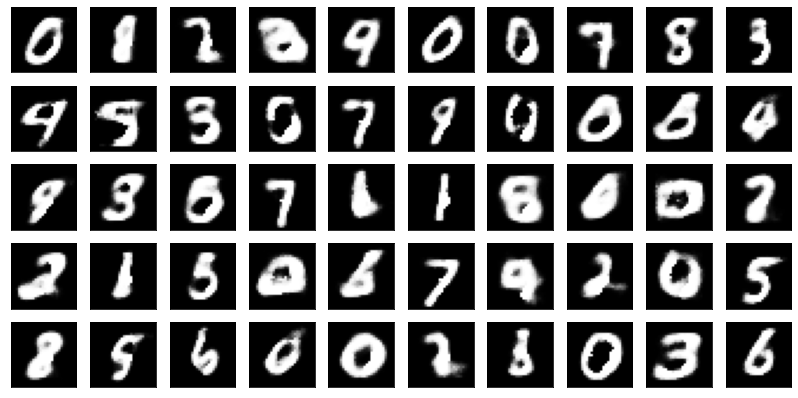

In [11]:
plot_samples(sample_vae(dec=dec))

In [12]:
def plot_reconstructions(loss, model):
    with torch.no_grad():
        batch = (test_loader.dataset.data[:25].float() / 255.)
        batch = (batch > 0.5).float()
        batch = batch.view(-1, D).to(device)
        _, rec = loss(batch, *model)
        rec = torch.sigmoid(rec)
        rec = rec.view(-1, 28, 28).cpu().numpy()
        batch = batch.view(-1, 28, 28).cpu().numpy()

        fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(14, 7),
                                 subplot_kw={'xticks': [], 'yticks': []})
        for i in range(25):
            axes[i % 5, 2 * (i // 5)].imshow(batch[i], cmap='gray')
            axes[i % 5, 2 * (i // 5) + 1].imshow(rec[i], cmap='gray')

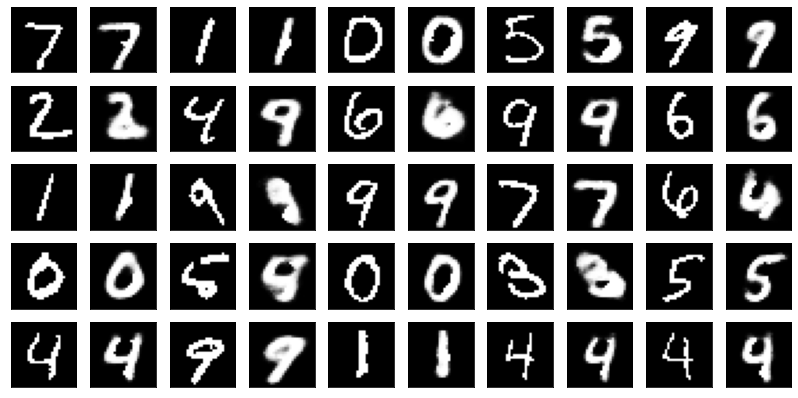

In [13]:
plot_reconstructions(loss_vae, [enc, dec])

In [14]:
def plot_interpolations(encoder, decoder):
    with torch.no_grad():
        batch = (test_loader.dataset.data[:10].float() / 255.)
        batch = (batch > 0.5).float()
        batch = batch.view(-1, D).to(device)
        batch = encoder(batch)
        z_0 = batch[:5, :d].view(5, 1, d)
        z_1 = batch[5:, :d].view(5, 1, d)

        alpha = torch.linspace(0., 1., 10).to(device)
        alpha = alpha.view(1, 10, 1)

        interpolations_z = (z_0 * alpha + z_1 * (1 - alpha))
        interpolations_z = interpolations_z.view(50, d)
        interpolations_x = torch.sigmoid(decoder(interpolations_z))
        interpolations_x = interpolations_x.view(5, 10, 28, 28).cpu().numpy()

    fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(14, 7),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i in range(50):
        axes[i // 10, i % 10].imshow(interpolations_x[i // 10, i % 10], cmap='gray')

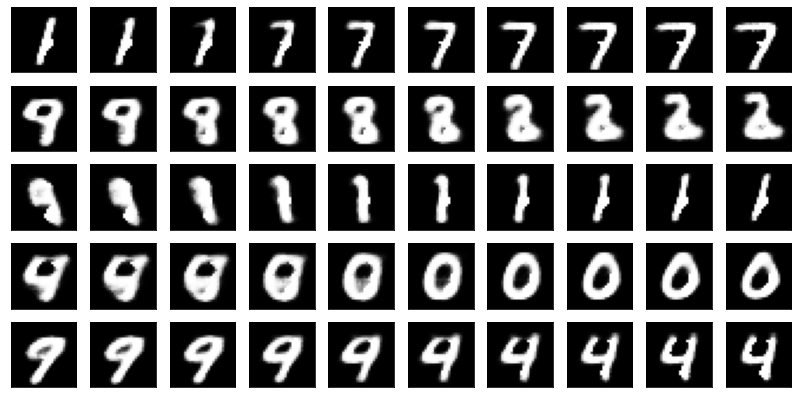

In [15]:
plot_interpolations(enc, dec)

In [16]:
def plot_tsne(objects, labels):
    from sklearn.manifold import TSNE
    embeddings = TSNE(n_components=2).fit_transform(objects)
    plt.figure(figsize=(8, 8))
    for k in range(10):
        embeddings_for_k = embeddings[labels == k]
        plt.scatter(embeddings_for_k[:, 0], embeddings_for_k[:, 1],
                    label='{}'.format(k))
    plt.legend()

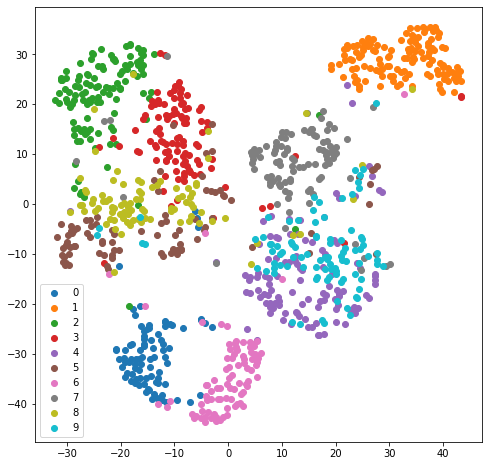

In [17]:
with torch.no_grad():
    batch = (test_loader.dataset.data[:1000].float() / 255.)
    batch = (batch > 0.5).float()
    batch = batch.view(-1, D).to(device)

    latent_variables = enc(batch)[:, :d]
    latent_variables = latent_variables.cpu().numpy()
    labels = test_loader.dataset.targets[:1000].numpy()

plot_tsne(latent_variables, labels)

The notebook implements a basic variational auto-encoder. Even with a toy architecture the model manages to learn a crude approximation of the data distribution.